In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import copy

import fnmatch
import soundfile as sf
import os
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from skimage import io
import torchaudio
import torchaudio.transforms as T
import librosa
import torch.nn.functional as F
import re

# Pre processing

In [3]:
# To convert a flac file into a spectrogramm

def flac_to_spectro(file_path):
  waveform, sample_rate = torchaudio.load(file_path, normalize=True)
  transform = T.MelSpectrogram(sample_rate)
  mel_specgram = transform(waveform)
  return mel_specgram  

In [4]:
# To plot the Melspectrogramm 

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


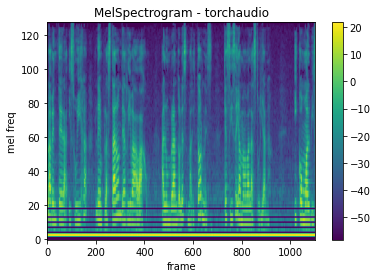

In [5]:
# Example
spectro = flac_to_spectro("/content/drive/MyDrive/neural networks project/test_set_es/data_sample/es_f_50298ab71aaba8508ebeef49d853df11.fragment17.flac")
plot_spectrogram(spectro[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

#⚠ Transform the labels into int to put them into a float tensor 

We assign Int to labels:


*   es = 0
*   en = 1
*   de = 2



In [6]:
def label2id(label):
  if 'es':
    return 0
  elif 'en':
    return 1
  elif 'de':
    return 2

In [7]:
class SpeechDataset(Dataset):

    def __init__(self, flac_dir):
        self.audio_path_list = sorted(self.find_files(flac_dir))
        # Conversion into spectrogramms 
        self.specto_data = []
        for f_path in self.audio_path_list:
          self.specto_data.append(flac_to_spectro(f_path))
        # TODO Convert it into an actual image ? I don't think so 
        self.labels = self._get_labels()

    def __len__(self):
        return len(self.specto_data)

    def __getitem__(self, index):
      # Retrieve the corresponding audio
        audio_path = self.audio_path_list[index]
        # transform it into a spectrogramm
        # Retrieve the corresponding spectrogram 
        spectro = self.specto_data[index]
        # Convert it to Tensor
        spectro = torch.FloatTensor(spectro)
        # Retrieve the corresponding label
        label = self.labels[index] 
        # Convert it to Tensor
        label = torch.LongTensor([label])
        return spectro, label

    def find_files(self, directory, pattern="*.flac"):
        """
        Recursive search method to find files. Credit to Paul Magron for OG method
        """
        audio_path_list = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                audio_path_list.append(os.path.join(root, filename))
        return audio_path_list
    
    def _get_labels(self):
      """Extract the labels from the given audio files."""
      labels = []
      for filepath in self.audio_path_list:
        label = re.findall("(es|en|de)_", filepath)[0] 
        label = label2id(label)
        labels.append(label)
      return labels

    def _get_label(self, audio_path):
      """Extract the label from the single given audio file."""
      label = re.findall("(es|en|fr|de)_", audio_path)[0] 
      return label


torch.Size([128, 1103])


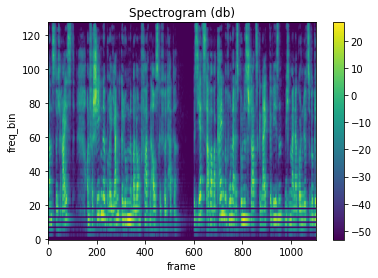

SPECTRO tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.0142e+00, 1.3737e-03, 2.3728e-03,  ..., 5.8068e-04,
          4.9118e-04, 7.9315e-01],
         ...,
         [1.7055e-04, 1.2002e-04, 3.8159e-05,  ..., 1.8790e-07,
          1.1436e-07, 3.1839e-06],
         [2.7711e-05, 2.8965e-05, 9.0205e-06,  ..., 1.2057e-07,
          1.6483e-07, 3.3972e-06],
         [3.1150e-06, 1.1325e-07, 8.5658e-08,  ..., 6.0862e-08,
          2.0011e-07, 4.0869e-06]]])
LABEL tensor([0])


In [8]:
data_dir = "/content/drive/MyDrive/neural networks project/test/"

# Prepare the Dataset
dataset = SpeechDataset(flac_dir=data_dir)

# Small example 
features_example = dataset.specto_data[0][0]
print(features_example.shape)
plot_spectrogram(features_example)

spectro, label = dataset.__getitem__(0)
print("SPECTRO", spectro)
print("LABEL", label)

## DataLoader

⚠ The slipt et son torch arrange à check !! 

In [9]:
# Prepare the Dataloader
train_data = Subset(dataset, torch.arange(389)) # 70% 
valid_data = Subset(dataset, torch.arange(43))  # 10%
test_data = Subset(dataset, torch.arange(108))  # 20%
print('Number of files in the train dataset', len(train_data))
print('Number of files in the valid dataset', len(valid_data))
print('Number of files in the test dataset', len(test_data))

# Create the dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
print('Number of files in the train DataLoader', len(train_dataloader))
print('Number of files in the valid DataLoader', len(valid_dataloader))
print('Number of files in the test DataLoader', len(test_dataloader))

Number of files in the train dataset 389
Number of files in the valid dataset 43
Number of files in the test dataset 108
Number of files in the train DataLoader 49
Number of files in the valid DataLoader 6
Number of files in the test DataLoader 14


In [10]:
# Initialization function
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
    return

## CNN 

We need to do hyperparameters tuning, for the first implem, I use a 3 layers CNN. With the last layer being a Linear one for simple classification. Paired with a Softmax activation function. 

In [11]:
class CNNClassif(nn.Module):
    def __init__(self, channels_in, num_channels1, num_channels2, kernel_size_conv, kernel_size_pool, padding, num_classes):
        super(CNNClassif, self).__init__()
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(channels_in, num_channels1, kernel_size=kernel_size_conv, padding=padding),
                           nn.ReLU(), 
                           nn.BatchNorm2d(num_channels1),
                           nn.MaxPool2d(kernel_size_pool))
        self.cnn_layer2 = nn.Sequential(
          nn.Conv2d(num_channels1, num_channels2, kernel_size=kernel_size_conv, padding=padding),
                           nn.ReLU(), 
                           nn.BatchNorm2d(num_channels2),
                           nn.MaxPool2d(kernel_size_pool))
        self.lin_layer = nn.Linear(8525*num_channels2, num_classes)  
        
    def forward(self, x):
      out = self.cnn_layer1(x)
      out = self.cnn_layer2(out)
      out = out.reshape(out.size(0), -1)
      out = self.lin_layer(out)
      return out 

# Evaluation 

In [12]:
# Eval function

def eval_cnn_classifier(model, eval_dataloader):

    # Set the model in evaluation mode
    model.eval() 

    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)  # TODO check this it seems weird .squeeze(1)
            correct += (label_predicted == labels).sum().item()  # TODO check this it seems weird .squeeze(1)
    
    accuracy = 100 * correct / total
    
    return accuracy

# Training function 

In [13]:
def training_cnn_classifier_with_eval(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):
    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)  # TODO not Adam right ? 
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    accuracy_val_all_epochs = []

    accuracy_opt = 0
    
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
   
            # Forward pass
            y_predicted = model_tr(images)

            # Backpropagation
            loss = loss_fn(y_predicted, labels.squeeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Add the batch loss to the current epoch loss
            loss_current_epoch += loss.item()

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        accuracy_current_epoch = eval_cnn_classifier(model_tr, valid_dataloader)
        accuracy_val_all_epochs.append(accuracy_current_epoch)

        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f} ; Validation accuracy: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch, accuracy_current_epoch))
        
        if accuracy_current_epoch > accuracy_opt:
            model_opt = copy.deepcopy(model_tr)
            accuracy_opt = accuracy_current_epoch

    return model_tr, loss_all_epochs, accuracy_val_all_epochs

In [21]:
# TODO Modulate the training parameters
num_epochs = 30  #20
learning_rate = 0.000001  #0.0001

# Default params:
#def_num_channels1 = 128  #16
#def_num_channels2 = 256  #32
channels_in = 1
def_kernel_size_conv = 2
def_kernel_size_pool = 2
def_padding = 0
num_classes = 3

In [ ]:
loss_fct = nn.CrossEntropyLoss()
test_model = CNNClassif(channels_in, 16, 32, def_kernel_size_conv, def_kernel_size_pool, def_padding, num_classes)

model, loss_all_epochs, accuracy_validation = training_cnn_classifier_with_eval(test_model, train_dataloader, valid_dataloader, num_epochs, loss_fct, learning_rate)

# Plot training log
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(loss_all_epochs)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(accuracy_validation)
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.show()